In [2]:
import datetime
import hydra
import json
import numpy as np
import os
import time
from PIL import Image
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets

# rcg
from config import RCGConfiguration

# rtk
from rtk._datasets import cxr14, create_transforms
from rtk.config import DatasetConfiguration, set_hydra_configuration
from rtk.mlflow import prepare_mlflow
from rtk.utils import get_logger, hydra_instantiate, _strip_target

In [3]:
%matplotlib inline

In [4]:
init_method_kwargs = {"config_dir": "/home/nicoleg/workspaces/rcg/config/"}
config_name = "rdm"

In [5]:
args = set_hydra_configuration(
    config_name,
    ConfigurationInstance=RCGConfiguration,
    init_method_kwargs=init_method_kwargs,
)

[15:29:36] INFO     rtk.config: Creating configuration: 'rdm'                                         ]8;id=812814;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/config.py\config.py]8;;\:]8;id=326916;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/config.py#294\294]8;;\
                    [0m                                                                                            

In [6]:

datasets = cxr14.load_cxr14_dataset(cfg=args)
dataset_train = datasets[0]

[15:29:37] INFO     rtk.utils: Patient dataset:             'cxr14_metadata'[0m                        ]8;id=841751;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/utils.py\utils.py]8;;\:]8;id=988335;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/utils.py#128\128]8;;\

[15:29:37] INFO     rtk.config: Creating 'train' transforms...[0m                                    ]8;id=556339;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/_datasets/__init__.py\__init__.py]8;;\:]8;id=689786;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/_datasets/__init__.py#41\41]8;;\

[15:29:38] INFO     rtk.config: Creating 'eval' transforms...[0m                                     ]8;id=885075;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/_datasets/__init__.py\__init__.py]8;;\:]8;id=480256;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/_datasets/__init__.py#43\43]8;;\

In [7]:
data_loader_train = hydra_instantiate(
    cfg=args.datasets.dataloader,
    dataset=dataset_train,
    pin_memory=torch.cuda.is_available() if torch.cuda.is_available() else False,
    shuffle=True,
)

In [8]:
samples, labels = next(iter(data_loader_train))

In [9]:
samples.shape

torch.Size([1, 1024, 256, 256])

In [10]:
samples._meta

{'format': ['PNG'],
 'mode': ['RGB'],
 'width': tensor([1024]),
 'height': tensor([1024]),
 spatial_shape: tensor([[1024, 1024]]),
 original_channel_dim: tensor([-1]),
 'filename_or_obj': ['/home/nicoleg/workspaces/dissertation/.data/CHEST_XRAY_14/00000358_000.png'],
 affine: tensor([[[ 4.0000,  0.0000,  0.0000,  1.5000],
          [ 0.0000,  0.0117,  0.0000, -0.4941],
          [ 0.0000,  0.0000,  1.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  1.0000]]], dtype=torch.float64)}

In [11]:
f = samples[0]._meta['filename_or_obj']
f

'/home/nicoleg/workspaces/dissertation/.data/CHEST_XRAY_14/00000358_000.png'

In [12]:
transforms = create_transforms(cfg=args)
transforms.transforms

[15:29:53] INFO     rtk.config: Creating 'train' transforms...[0m                                    ]8;id=47098;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/_datasets/__init__.py\__init__.py]8;;\:]8;id=113843;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/_datasets/__init__.py#41\41]8;;\

(<monai.transforms.spatial.array.Resize at 0x7f1e66748370>,
 RandomCrop(size=(256, 256), padding=None),
 RandomHorizontalFlip(p=0.5),
 <monai.transforms.utility.array.ToTensor at 0x7f1f846d88b0>)

In [13]:
img = Image.open(f)
np.array(img).shape

(1024, 1024, 3)

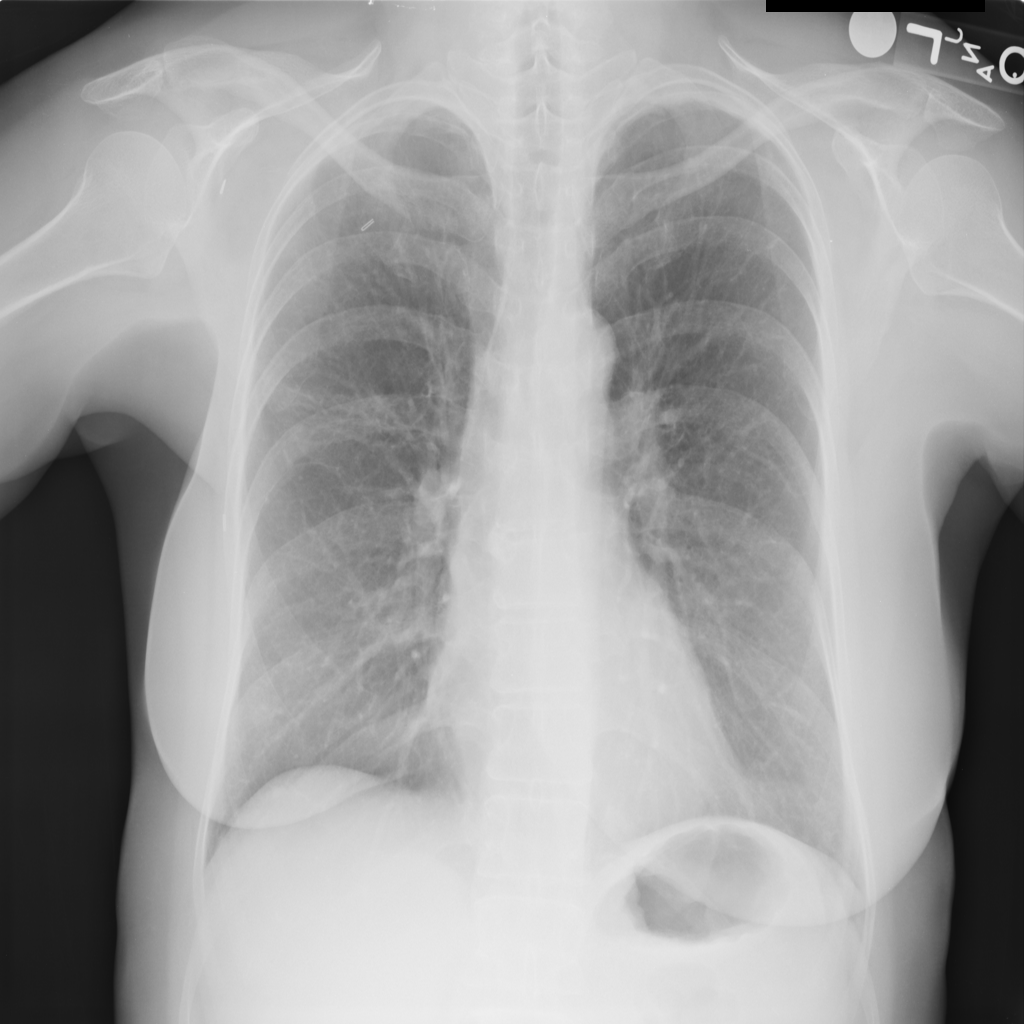

In [14]:
img

In [15]:
import monai
import torchvision

size = args.datasets.dim
load_image = monai.transforms.LoadImage(image_only=True, ensure_channel_first=True)
img = load_image(f)
img.shape

torch.Size([3, 1024, 1024])

In [16]:
resize = torchvision.transforms.Resize(size, interpolation=3)
resize(img).shape

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


torch.Size([3, 256, 256])